# 3. 회귀분석

In [2]:
# 라이브러리 import
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
pd.options.display.float_format = lambda x: f'{x:.10f}'
pd.set_option('display.max_rows', 5000)

import matplotlib.pyplot as plt
plt.rc("font", family = "Malgun Gothic")
plt.rc("axes", unicode_minus = False)
import matplotlib as mpl
import seaborn as sns

from geoband.API import *
import re
import geopandas as gpd
import json
import geojson
import folium
from folium.plugins import MarkerCluster
import requests 
from urllib.parse import urlparse
import warnings
warnings.filterwarnings('ignore')

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 3.1. 학습데이터 및 독립변수, 종속변수 선정

### (1) 학습데이터 선정

In [3]:
# 회귀분석에 이용할 최종데이터 불러오기
격자별_최종데이터=pd.read_csv('최종데이터/격자별_최종데이터-Copy1.ver4', encoding='utf-8').drop('Unnamed: 0', axis=1)
격자별_최종데이터.fillna(0, inplace=True)
격자별_최종데이터 = 격자별_최종데이터.replace([np.inf, -np.inf], 0)
격자별_최종데이터.columns

Index(['Unnamed: 0.1', 'id', 'geometry', 'coordinates', 'geo_cent', 'grid_id',
       '행정동', '가구수', '정규화_가구수', '백분율가구수', '인구수', '운전가능인구', '자동차등록수', '주차가능차량수',
       '주차면수', '정규화_주차면수', '주차장확보율', '불법주정차', '정규화_불법주정차', '버스', '지하철',
       '정규화_버스', '정규화_지하철', '주거시설', '정규화_주거시설'],
      dtype='object')

In [4]:
격자별_최종데이터['주차장확보율'].describe() # 주차장확보율이 30,000 넘어가는 outlier 존재

count     543.0000000000
mean       64.3616304934
std      1345.7362524120
min         0.0000000000
25%         0.0000000000
50%         0.0000000000
75%         1.0236323978
max     31354.7677616314
Name: 주차장확보율, dtype: float64

In [5]:
# 학습데이터 필터링
회귀모델 = 격자별_최종데이터[(격자별_최종데이터['주차장확보율']>0.8)&(격자별_최종데이터['주차장확보율']<10)&(격자별_최종데이터['가구수']!=0)]

### (2) 독립변수, 종속변수 선정
#### [1] 산점도 및 회귀선

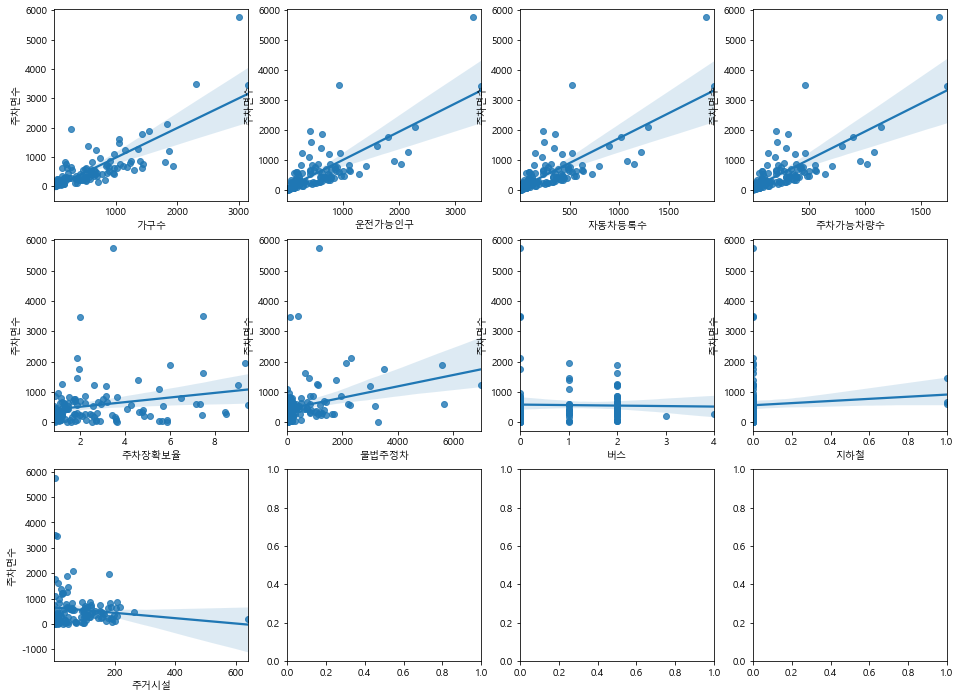

In [6]:
fig, axs = plt.subplots(figsize=(16,12), nrows=3, ncols=4)
x_features = ["가구수","운전가능인구","자동차등록수","주차가능차량수","주차장확보율","불법주정차","버스","지하철","주거시설"]
for i, feature in enumerate(x_features):    
    #현재 subplot의 행, 열 번호 갱신
    row = int(i/4) #column이 4개이므로
    col = i%4
    #산점도와 회귀선 시각화
    sns.regplot(x=feature, y='주차면수', data=회귀모델, ax=axs[row][col])

#### [2] 컬럼별 독립변수 간의 상관관계 시각화(다중공선성이 의심되는 독립변수들)

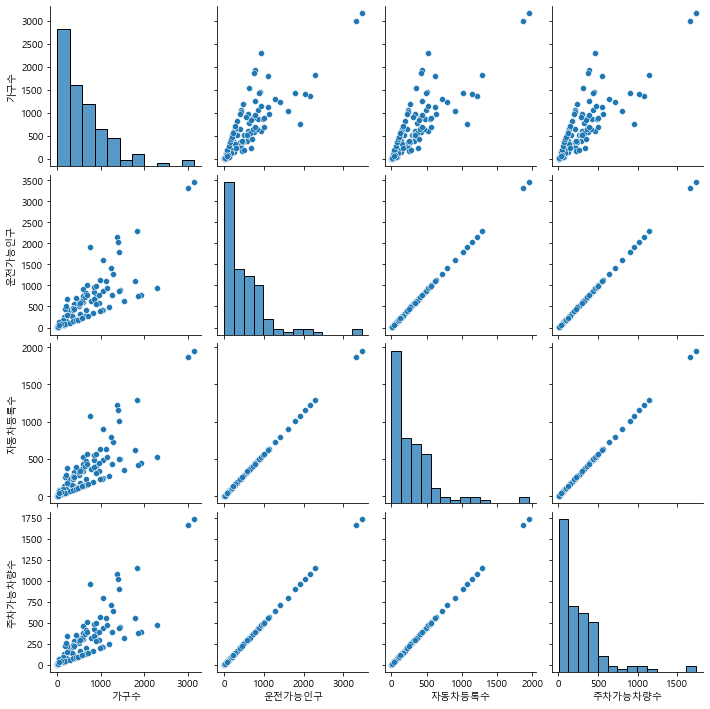

In [7]:
# 전체 컬럼에서 상호간의 관계를 파악할 변수들
ccol = ['가구수','운전가능인구', '자동차등록수', '주차가능차량수']

#pairplot 시각화
sns.pairplot(회귀모델[ccol])

<AxesSubplot:>

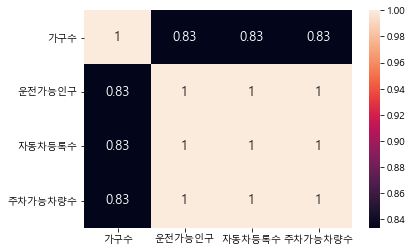

In [8]:
# 변수 간의 상관계수 계산
corrs = 회귀모델[ccol].corr()

# 상관계수 값에 대한 히트맵
# 매개변수 annot: 맵에 값 표시 여부 지정
# 매개변수 annot_kws: 표시되는 값에 대한 추가 옵션
sns.heatmap(corrs, annot=True, annot_kws={'size':13})

#### [3] 독립변수, 종속변수 선정

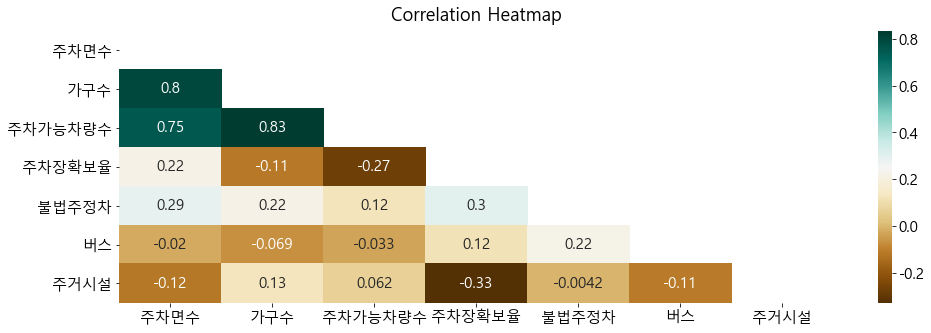

In [9]:
# 다중공산성으로 보이는 "운전가능인구", 자동차등록수" 제거
# 6개의 행에만 존재하는 "지하철" 제거

X = 회귀모델[["가구수","주차가능차량수","주차장확보율","불법주정차","버스","주거시설"]] # 독립변수
y = 회귀모델["주차면수"] # 종속변수

# 독립변수, 종속변수 상관관계 히트맵
mask = np.triu(np.ones_like(pd.concat([y,X], axis=1).corr(), dtype=np.bool))
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(pd.concat([y,X], axis=1).corr(), 
            annot=True, 
            cmap="BrBG", 
            mask = mask)
ax.set_title('Correlation Heatmap', pad = 10)
plt.show()

* 독립변수, 종속변수만 포함한 최종 학습데이터 선정

In [10]:
최종데이터_수치만 = pd.concat([y,X], axis=1)
최종데이터_수치만

,주차면수,가구수,주차가능차량수,주차장확보율,불법주정차,버스,주거시설
11,1957.0000000000,275.0000000000,209.3562920044,9.3477009039,2141.0000000000,1,183
12,652.0000000000,268.0000000000,204.0272227534,3.1956519880,707.0000000000,2,189
14,583.0000000000,606.0000000000,461.3451380170,1.2636959880,845.0000000000,1,58
15,1471.0000000000,1051.0000000000,800.1216832605,1.8384703612,785.0000000000,1,47
17,268.0000000000,155.0000000000,122.4325114099,2.1889610604,115.0000000000,2,48
18,40.0000000000,14.0000000000,11.0584203854,3.6171531381,174.0000000000,0,6
19,65.0000000000,14.0000000000,11.0584203854,5.8778738495,18.0000000000,0,15
20,30.0000000000,58.0000000000,28.8312952726,1.0405359772,43.0000000000,2,73
30,2108.0000000000,1830.0000000000,1148.2611869793,1.8358192578,2293.0000000000,0,62
31,576.0000000000,499.0000000000,313.1050996190,1.8396378746,1186.0000000000,1,53


## 3.2. 회귀모델 선정
### (1) 회귀모델 성능 평가지표 : 결정계수($R^2$)
* 실제값의 분산 대비 예측값의 분산 비율
* 결정 계수의 값은 0 ≤ R2 ≤ 1이며 1에 가까울수록 설명력이 강하고, 0에 가까울수록 설명력이 약하다.

In [11]:
# 회귀모델 import
from sklearn import model_selection
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [12]:
X

,가구수,주차가능차량수,주차장확보율,불법주정차,버스,주거시설
11,275.0000000000,209.3562920044,9.3477009039,2141.0000000000,1,183
12,268.0000000000,204.0272227534,3.1956519880,707.0000000000,2,189
14,606.0000000000,461.3451380170,1.2636959880,845.0000000000,1,58
15,1051.0000000000,800.1216832605,1.8384703612,785.0000000000,1,47
17,155.0000000000,122.4325114099,2.1889610604,115.0000000000,2,48
18,14.0000000000,11.0584203854,3.6171531381,174.0000000000,0,6
19,14.0000000000,11.0584203854,5.8778738495,18.0000000000,0,15
20,58.0000000000,28.8312952726,1.0405359772,43.0000000000,2,73
30,1830.0000000000,1148.2611869793,1.8358192578,2293.0000000000,0,62
31,499.0000000000,313.1050996190,1.8396378746,1186.0000000000,1,53


In [13]:
y

11    1957.0000000000
12     652.0000000000
14     583.0000000000
15    1471.0000000000
17     268.0000000000
18      40.0000000000
19      65.0000000000
20      30.0000000000
30    2108.0000000000
31     576.0000000000
32    1268.0000000000
35      64.0000000000
36     217.0000000000
48     456.0000000000
50     253.0000000000
52     406.0000000000
55       7.0000000000
74     294.0000000000
78      20.0000000000
79      58.0000000000
94     868.0000000000
96     627.0000000000
102    670.0000000000
107     13.0000000000
119     58.0000000000
122     79.0000000000
123   3464.0000000000
128    537.0000000000
129    428.0000000000
131    330.0000000000
147     51.0000000000
148    263.0000000000
153    709.0000000000
154     62.0000000000
156    441.0000000000
157    625.0000000000
160    795.0000000000
169    343.0000000000
176   1381.0000000000
177    284.0000000000
178    502.0000000000
179     64.0000000000
187    241.0000000000
195    813.0000000000
196   1607.0000000000
200    114

In [14]:
from sklearn import model_selection

# 학습데이터 내 train, test set 생성
x_data = X
y_data = y
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.1,random_state=42)

In [15]:
# 회귀모델 성능 평가 함수
# 평가지표 = 결정계수(R2 score)

from sklearn.metrics import r2_score
my_predictions = {}
my_pred = None
my_actual = None
my_name = None

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato']

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(11, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def r2_eval(name_, pred, actual):
    global my_predictions, colors, my_pred, my_actual, my_name
    
    my_name = name_
    my_pred = pred
    my_actual = actual
    
    plot_predictions(name_, pred, actual)
    
    r2 = r2_score(actual, pred)

    print('r2 score = {:.3f}'.format(r2))
    my_predictions[name_] = r2
    
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'r2'])
    print(df)
    min_ = df['r2'].min() - 10
    max_ = df['r2'].max() + 10
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['r2'], height=0.3)
    
    for i, v in enumerate(df['r2']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('r2 score', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()

def add_model(name_, pred, actual):
    global my_predictions, my_pred, my_actual, my_name
    my_name = name_
    my_pred = pred
    my_actual = actual
    
    r2 = r2_score(actual, pred)
    my_predictions[name_] = r2

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

def plot_all():
    global my_predictions, my_pred, my_actual, my_name
    
    plot_predictions(my_name, my_pred, my_actual)
    
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'r2'])
    print(df)
    min_ = df['r2'].min() - 10
    max_ = df['r2'].max() + 10
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['r2'], height=0.3)
    
    for i, v in enumerate(df['r2']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('r2 score', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()

#### 1. 규제가 없는 선형회귀모델 (LinearRegression)

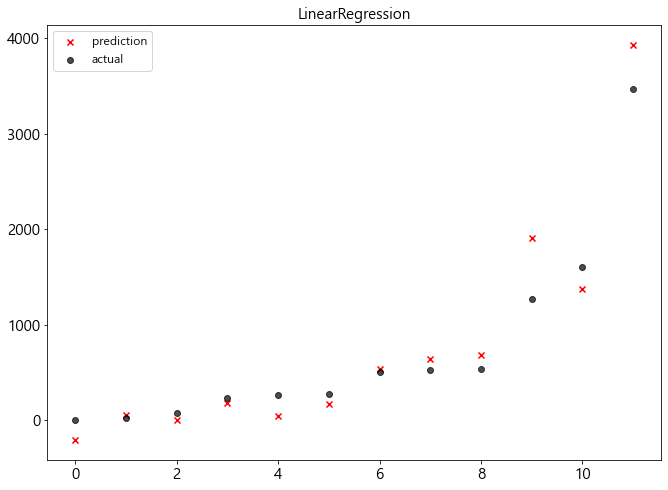

r2 score = 0.922
              model           r2
0  LinearRegression 0.9224053379


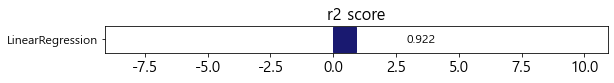

In [16]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(n_jobs=-1)
model.fit(x_train, y_train)
pred = model.predict(x_test)
r2_eval('LinearRegression', pred, y_test)

In [17]:
linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)
pred = linear_reg.predict(x_test)
#r2_eval('LinearRegression', pred, y_test)

#### 2. 규제가 있는 선형회귀모델 ▶ 릿지 (Ridge)
* 회귀 모델에 L2규제(가중치의 제곱)를 추가
* 𝛼 = 0 이면 선형회귀와 동일하다.
* 𝛼가 매우 크면 모든 가중치가 0 에 가까워진다 : 강한 규제

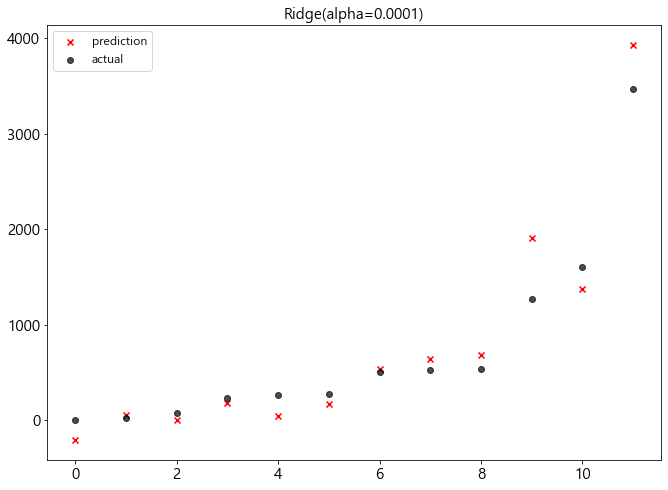

                 model           r2
0     Ridge(alpha=100) 0.9292676297
1      Ridge(alpha=10) 0.9234800922
2       Ridge(alpha=1) 0.9225178884
3     Ridge(alpha=0.1) 0.9224166448
4    Ridge(alpha=0.01) 0.9224064691
5   Ridge(alpha=0.001) 0.9224054511
6  Ridge(alpha=0.0001) 0.9224053492
7     LinearRegression 0.9224053379


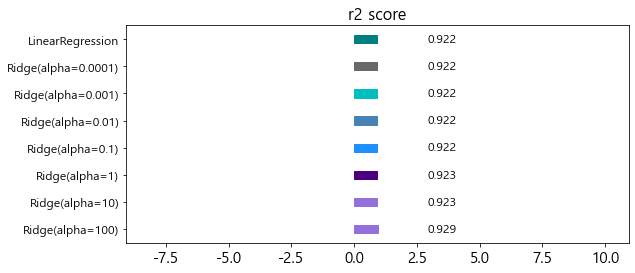

In [18]:
from sklearn.linear_model import Ridge

# 값이 커질수록 큰 규제
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=42)
    ridge.fit(x_train, y_train)
    pred = ridge.predict(x_test)
    add_model('Ridge(alpha={})'.format(alpha), pred, y_test)
plot_all()

In [19]:
ridge = Ridge(alpha=100) # L2 규제계수 alpha=100
ridge.fit(x_train, y_train)
pred = ridge.predict(x_test)
#r2_eval('Ridge(alpha=100)', pred, y_test)

#### 3. 규제가 있는 선형회귀모델 ▶ 라쏘 (Lasso)
* 회귀 모델에 L1규제(가중치의 절대값에 대한 규제)를 추가

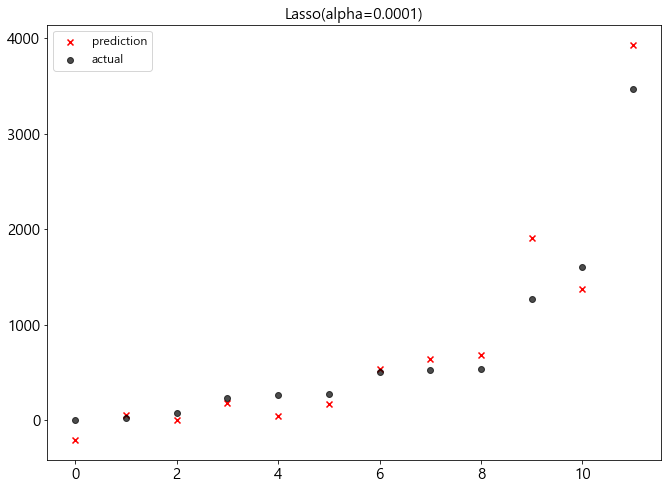

                  model           r2
0      Lasso(alpha=100) 0.9296301631
1      Ridge(alpha=100) 0.9292676297
2       Ridge(alpha=10) 0.9234800922
3       Lasso(alpha=10) 0.9228892912
4        Ridge(alpha=1) 0.9225178884
5        Lasso(alpha=1) 0.9224613302
6      Ridge(alpha=0.1) 0.9224166448
7      Lasso(alpha=0.1) 0.9224110126
8     Ridge(alpha=0.01) 0.9224064691
9     Lasso(alpha=0.01) 0.9224059062
10   Ridge(alpha=0.001) 0.9224054511
11   Lasso(alpha=0.001) 0.9224053948
12  Ridge(alpha=0.0001) 0.9224053492
13  Lasso(alpha=0.0001) 0.9224053436
14     LinearRegression 0.9224053379


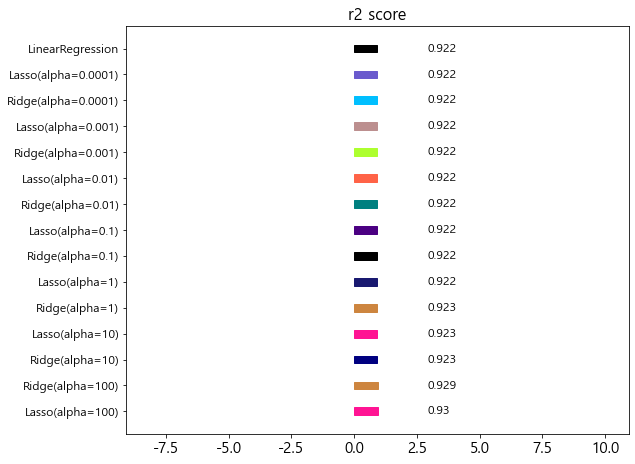

In [20]:
from sklearn.linear_model import Lasso

# 값이 커질 수록 큰 규제
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)
    pred = lasso.predict(x_test)
    add_model('Lasso(alpha={})'.format(alpha), pred, y_test)
plot_all()

In [21]:
lasso = Lasso(alpha=100) # L1 규제계수 alpha=100
lasso.fit(x_train, y_train)
pred = lasso.predict(x_test)
#r2_eval('Lasso(alpha=100)', pred, y_test)

#### 4. 규제가 있는 선형회귀모델 ▶엘라스틱넷 (ElasticNet)
* L1 규제와 L2규제를 혼합한 회귀로, 두 종류의 규제를 혼합하여 릿지 회귀와 라쏘 회귀의 절충 형태를 학습 모델로 도출한다.
* 𝛼는 규제 매개변수이고 ratio는 혼합 비율이다.
* ratio=0 : L2 규제와 동일하므로 릿지 회귀
* ratio=1 : L1 규제와 동일하므로 라쏘 회귀

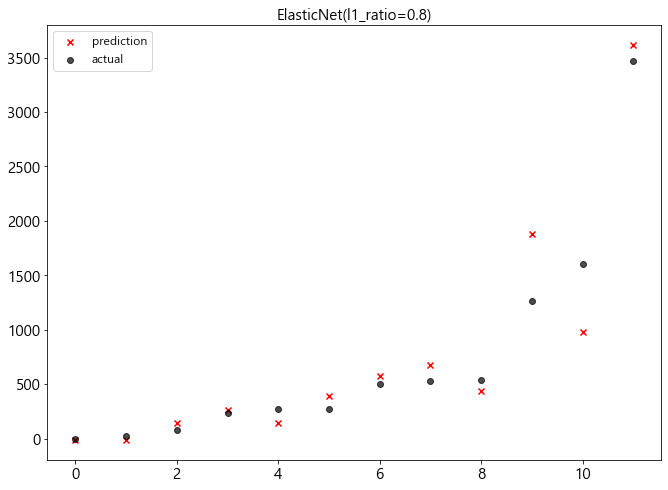

                       model           r2
0           Lasso(alpha=100) 0.9296301631
1           Ridge(alpha=100) 0.9292676297
2            Ridge(alpha=10) 0.9234800922
3            Lasso(alpha=10) 0.9228892912
4             Ridge(alpha=1) 0.9225178884
5             Lasso(alpha=1) 0.9224613302
6           Ridge(alpha=0.1) 0.9224166448
7           Lasso(alpha=0.1) 0.9224110126
8          Ridge(alpha=0.01) 0.9224064691
9          Lasso(alpha=0.01) 0.9224059062
10        Ridge(alpha=0.001) 0.9224054511
11        Lasso(alpha=0.001) 0.9224053948
12       Ridge(alpha=0.0001) 0.9224053492
13       Lasso(alpha=0.0001) 0.9224053436
14          LinearRegression 0.9224053379
15  ElasticNet(l1_ratio=0.8) 0.9201655048
16  ElasticNet(l1_ratio=0.5) 0.9168135059
17  ElasticNet(l1_ratio=0.2) 0.9157586318


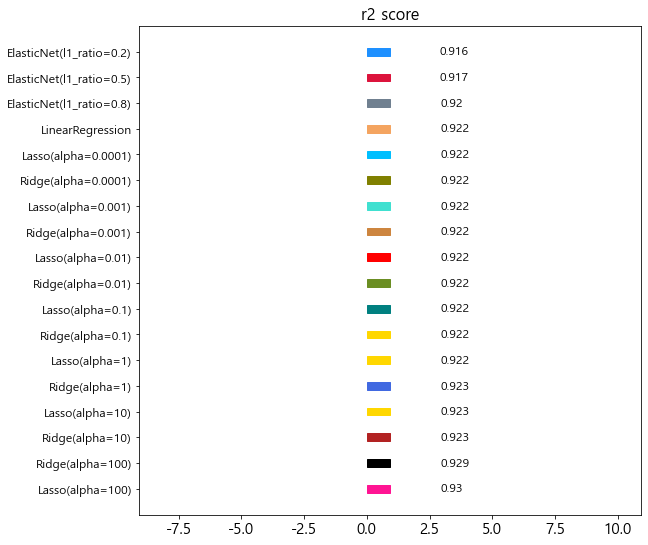

In [22]:
from sklearn.linear_model import ElasticNet

alpha=100
ratios = [0.2, 0.5, 0.8]

for ratio in ratios:
    elasticnet = ElasticNet(alpha=alpha, l1_ratio=ratio, random_state=42)
    elasticnet.fit(x_train, y_train)
    pred = elasticnet.predict(x_test)
    add_model('ElasticNet(l1_ratio={})'.format(ratio), pred, y_test)
plot_all()

In [23]:
elasticnet = ElasticNet(alpha=100, l1_ratio=0.8)
elasticnet.fit(x_train, y_train)
pred = elasticnet.predict(x_test)
#r2_eval('ElasticNet(alpha=100, l1_ratio=0.8)', pred, y_test) 

#### 5. 보팅 (Voting) 앙상블
* 앙상블(Ensemble) : 여러 개의 약한 분류기(Weak Learner)를 생성하고, 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출
* 앙상블 기법의 종류 \
1) 보팅 (Voting): 서로 다른 ML 알고리즘으로 여러 개의 분류기를 생성하고, 투표(Vote)를 통해 최종 예측 결과를 결정하는 방식 \
2) 배깅 (Bagging): 서로 다른 데이터으로 여러 개의 분류기를 생성하고, 투표(Vote)를 통해 최종 예측 결과를 결정하는 방식 \
3) 부스팅 (Boosting): 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 개선시키는 방식

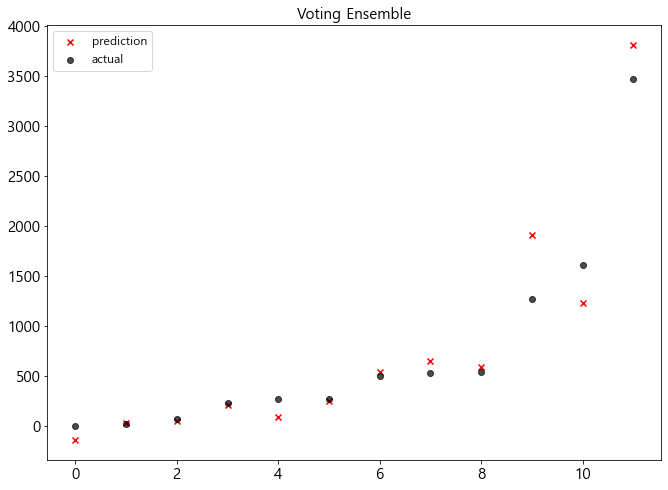

r2 score = 0.931
                       model           r2
0            Voting Ensemble 0.9312117513
1           Lasso(alpha=100) 0.9296301631
2           Ridge(alpha=100) 0.9292676297
3            Ridge(alpha=10) 0.9234800922
4            Lasso(alpha=10) 0.9228892912
5             Ridge(alpha=1) 0.9225178884
6             Lasso(alpha=1) 0.9224613302
7           Ridge(alpha=0.1) 0.9224166448
8           Lasso(alpha=0.1) 0.9224110126
9          Ridge(alpha=0.01) 0.9224064691
10         Lasso(alpha=0.01) 0.9224059062
11        Ridge(alpha=0.001) 0.9224054511
12        Lasso(alpha=0.001) 0.9224053948
13       Ridge(alpha=0.0001) 0.9224053492
14       Lasso(alpha=0.0001) 0.9224053436
15          LinearRegression 0.9224053379
16  ElasticNet(l1_ratio=0.8) 0.9201655048
17  ElasticNet(l1_ratio=0.5) 0.9168135059
18  ElasticNet(l1_ratio=0.2) 0.9157586318


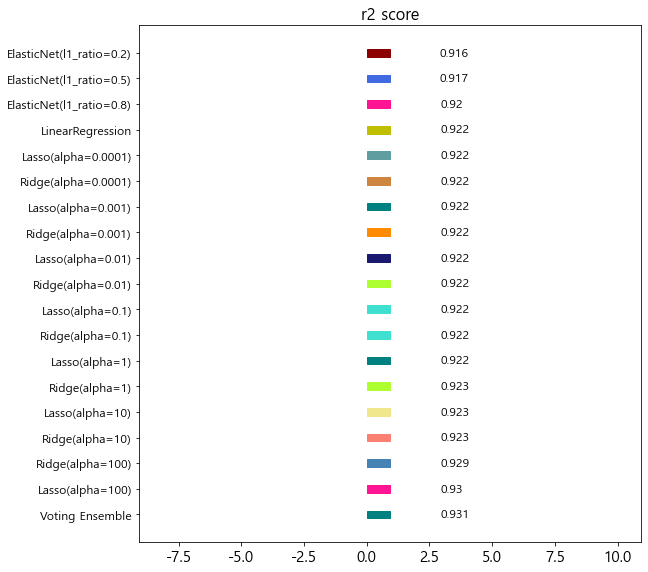

In [24]:
from sklearn.ensemble import VotingRegressor

single_models = [
    ('linear_reg', linear_reg), 
    ('ridge', ridge), 
    ('lasso', lasso), 
    ('elasticnet', elasticnet)
]

voting_regressor = VotingRegressor(single_models, n_jobs=-1)

voting_regressor.fit(x_train, y_train)

voting_pred = voting_regressor.predict(x_test)

r2_eval('Voting Ensemble', voting_pred, y_test)

#### 6. 배깅 (Bagging) 앙상블 ▶ 랜덤포레스트 (RandomForest)
* 가장 대표적이고 많이 활용되는 배깅 방식의 학습 기법
* 배깅 방식 + 결정트리 (Decision Tree)
* 모든 피쳐로 학습하지 말고, 랜덤하게 선택된 일부의 피쳐로만 학습

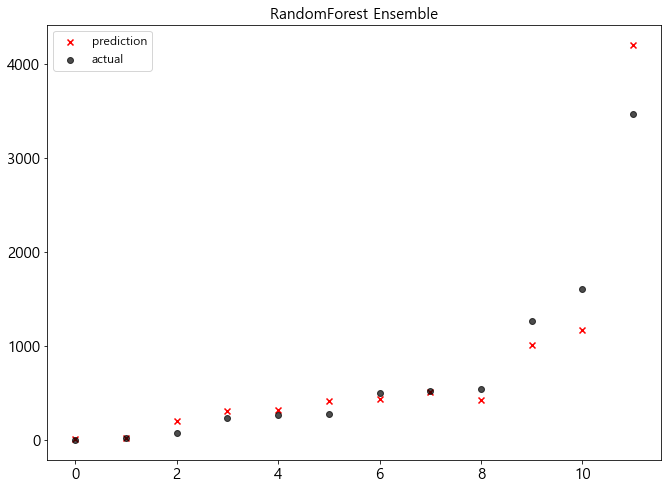

r2 score = 0.920
                       model           r2
0            Voting Ensemble 0.9312117513
1           Lasso(alpha=100) 0.9296301631
2           Ridge(alpha=100) 0.9292676297
3            Ridge(alpha=10) 0.9234800922
4            Lasso(alpha=10) 0.9228892912
5             Ridge(alpha=1) 0.9225178884
6             Lasso(alpha=1) 0.9224613302
7           Ridge(alpha=0.1) 0.9224166448
8           Lasso(alpha=0.1) 0.9224110126
9          Ridge(alpha=0.01) 0.9224064691
10         Lasso(alpha=0.01) 0.9224059062
11        Ridge(alpha=0.001) 0.9224054511
12        Lasso(alpha=0.001) 0.9224053948
13       Ridge(alpha=0.0001) 0.9224053492
14       Lasso(alpha=0.0001) 0.9224053436
15          LinearRegression 0.9224053379
16  ElasticNet(l1_ratio=0.8) 0.9201655048
17     RandomForest Ensemble 0.9198740374
18  ElasticNet(l1_ratio=0.5) 0.9168135059
19  ElasticNet(l1_ratio=0.2) 0.9157586318


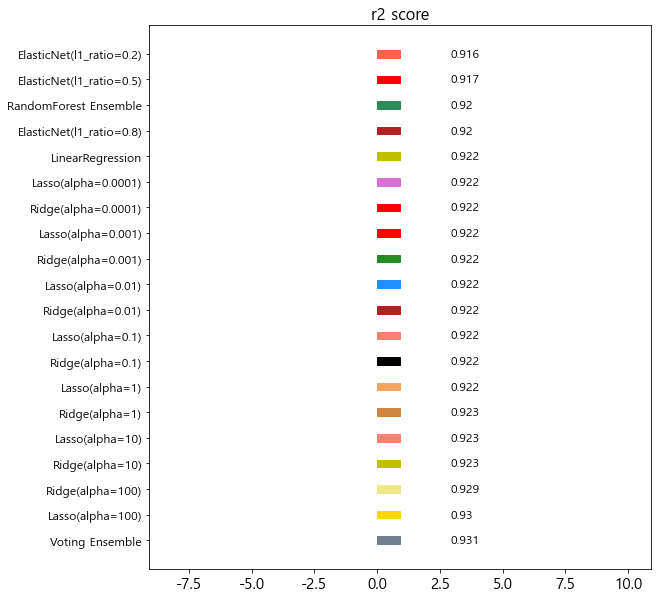

In [25]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)

rfr_pred = rfr.predict(x_test)
r2_eval('RandomForest Ensemble', rfr_pred, y_test)

In [26]:
params = {
    'n_estimators': [100, 500, 1000], 
    'max_depth': [7, 8], 
    'max_features': [0.8, 0.9],
}

In [27]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(RandomForestRegressor(), params, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 8], 'max_features': [0.8, 0.9],
                         'n_estimators': [100, 500, 1000]},
             scoring='r2')

In [28]:
grid_search.best_params_

{'max_depth': 7, 'max_features': 0.8, 'n_estimators': 100}

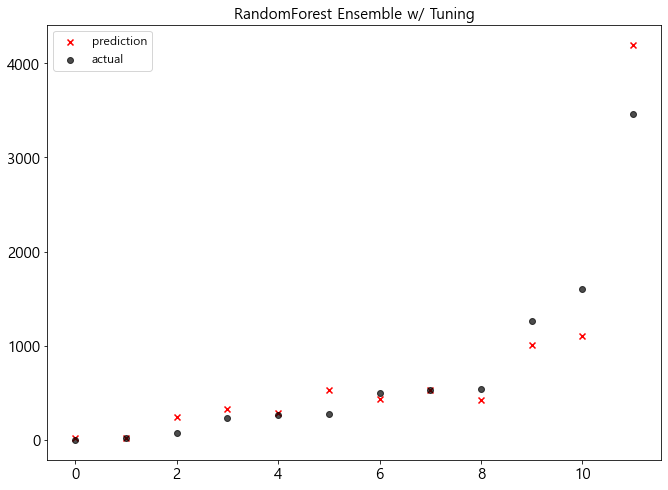

r2 score = 0.910
                              model           r2
0                   Voting Ensemble 0.9312117513
1                  Lasso(alpha=100) 0.9296301631
2                  Ridge(alpha=100) 0.9292676297
3                   Ridge(alpha=10) 0.9234800922
4                   Lasso(alpha=10) 0.9228892912
5                    Ridge(alpha=1) 0.9225178884
6                    Lasso(alpha=1) 0.9224613302
7                  Ridge(alpha=0.1) 0.9224166448
8                  Lasso(alpha=0.1) 0.9224110126
9                 Ridge(alpha=0.01) 0.9224064691
10                Lasso(alpha=0.01) 0.9224059062
11               Ridge(alpha=0.001) 0.9224054511
12               Lasso(alpha=0.001) 0.9224053948
13              Ridge(alpha=0.0001) 0.9224053492
14              Lasso(alpha=0.0001) 0.9224053436
15                 LinearRegression 0.9224053379
16         ElasticNet(l1_ratio=0.8) 0.9201655048
17            RandomForest Ensemble 0.9198740374
18         ElasticNet(l1_ratio=0.5) 0.9168135059
19 

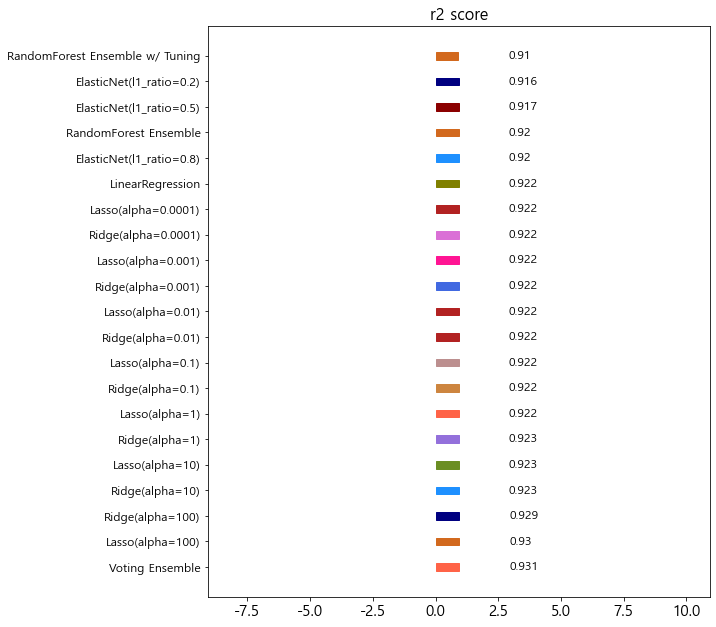

In [29]:
# 튜닝
rfr = RandomForestRegressor(random_state=42, **grid_search.best_params_)
rfr.fit(x_train, y_train)
rfr_pred = rfr.predict(x_test)
r2_eval('RandomForest Ensemble w/ Tuning', rfr_pred, y_test)

#### 7. 부스팅 (Boosting) 앙상블 ▶ GBM (GradientBoostingMachine)
* 부스팅 기법들 간의 차이는 오분류 데이터를 다음 모델에 어떻게 반영할 것인가의 차이
* Gradient Boosting은 이전 모델의 오류(잔차, residual)를 예측하는 새로운 모델을 생성
* Loss Function의 Gradient를 통해 오답에 가중치 부여

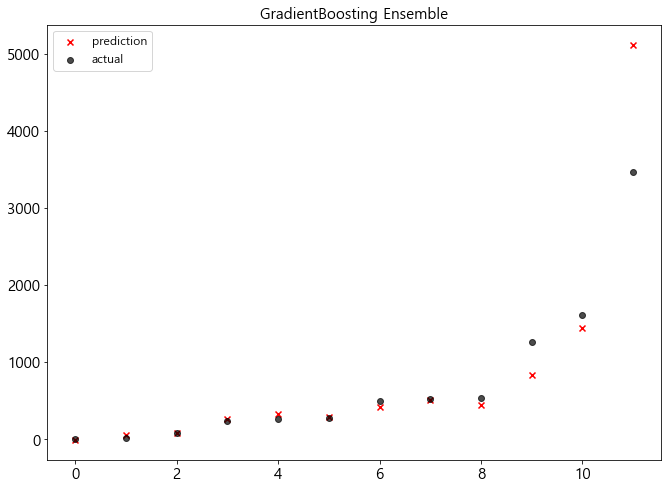

r2 score = 0.725
                              model           r2
0                   Voting Ensemble 0.9312117513
1                  Lasso(alpha=100) 0.9296301631
2                  Ridge(alpha=100) 0.9292676297
3                   Ridge(alpha=10) 0.9234800922
4                   Lasso(alpha=10) 0.9228892912
5                    Ridge(alpha=1) 0.9225178884
6                    Lasso(alpha=1) 0.9224613302
7                  Ridge(alpha=0.1) 0.9224166448
8                  Lasso(alpha=0.1) 0.9224110126
9                 Ridge(alpha=0.01) 0.9224064691
10                Lasso(alpha=0.01) 0.9224059062
11               Ridge(alpha=0.001) 0.9224054511
12               Lasso(alpha=0.001) 0.9224053948
13              Ridge(alpha=0.0001) 0.9224053492
14              Lasso(alpha=0.0001) 0.9224053436
15                 LinearRegression 0.9224053379
16         ElasticNet(l1_ratio=0.8) 0.9201655048
17            RandomForest Ensemble 0.9198740374
18         ElasticNet(l1_ratio=0.5) 0.9168135059
19 

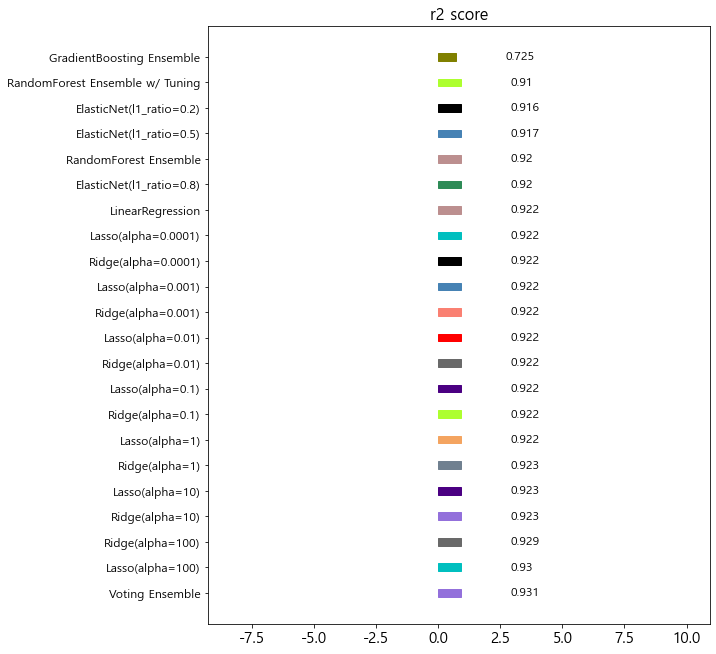

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)

gbr_pred = gbr.predict(x_test)
r2_eval('GradientBoosting Ensemble', gbr_pred, y_test)

In [31]:
params = {
    'n_estimators': [100, 500, 1000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'subsample': [0.7, 0.8, 0.9],
}

In [32]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(GradientBoostingRegressor(), params, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='r2')

In [33]:
grid_search.best_params_

{'learning_rate': 0.05, 'n_estimators': 500, 'subsample': 0.7}

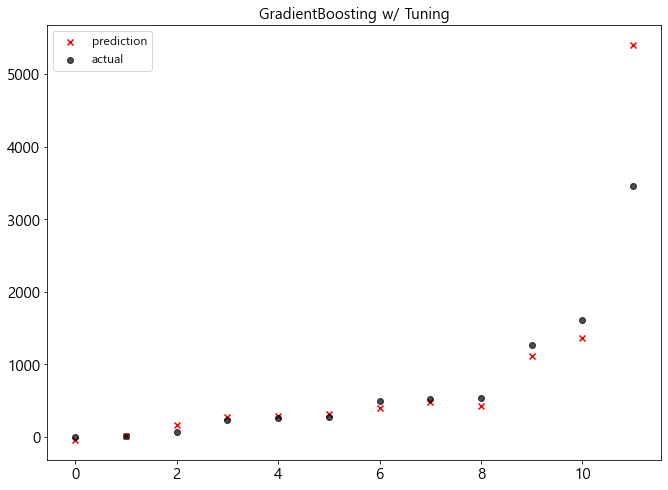

r2 score = 0.640
                              model           r2
0                   Voting Ensemble 0.9312117513
1                  Lasso(alpha=100) 0.9296301631
2                  Ridge(alpha=100) 0.9292676297
3                   Ridge(alpha=10) 0.9234800922
4                   Lasso(alpha=10) 0.9228892912
5                    Ridge(alpha=1) 0.9225178884
6                    Lasso(alpha=1) 0.9224613302
7                  Ridge(alpha=0.1) 0.9224166448
8                  Lasso(alpha=0.1) 0.9224110126
9                 Ridge(alpha=0.01) 0.9224064691
10                Lasso(alpha=0.01) 0.9224059062
11               Ridge(alpha=0.001) 0.9224054511
12               Lasso(alpha=0.001) 0.9224053948
13              Ridge(alpha=0.0001) 0.9224053492
14              Lasso(alpha=0.0001) 0.9224053436
15                 LinearRegression 0.9224053379
16         ElasticNet(l1_ratio=0.8) 0.9201655048
17            RandomForest Ensemble 0.9198740374
18         ElasticNet(l1_ratio=0.5) 0.9168135059
19 

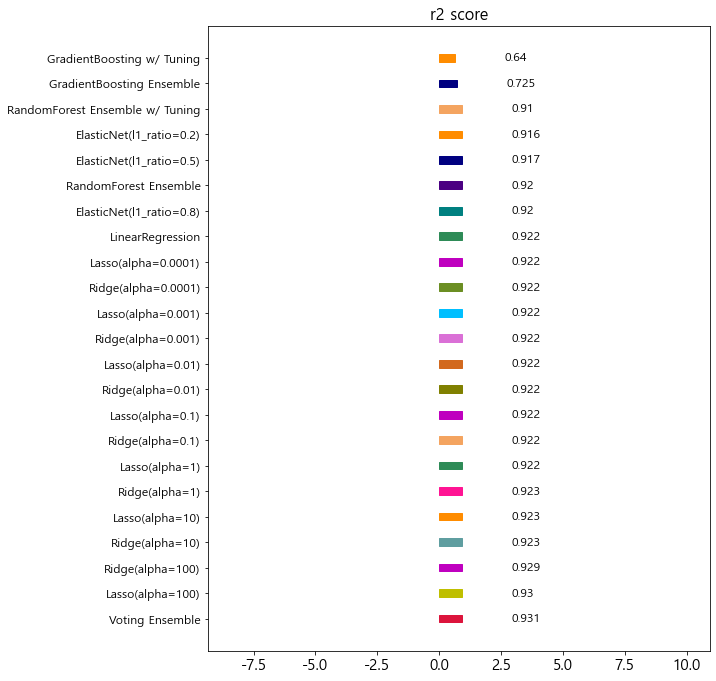

In [34]:
# 튜닝
gbr = GradientBoostingRegressor(**grid_search.best_params_)
gbr.fit(x_train, y_train)
gbr_pred = gbr.predict(x_test)
r2_eval('GradientBoosting w/ Tuning', gbr_pred, y_test)

#### 8. 부스팅 (Boosting) 앙상블 ▶ XGBoost (eXtreme Gradient Boost)
* GBM 기반으로 구현 & Upgrade Version

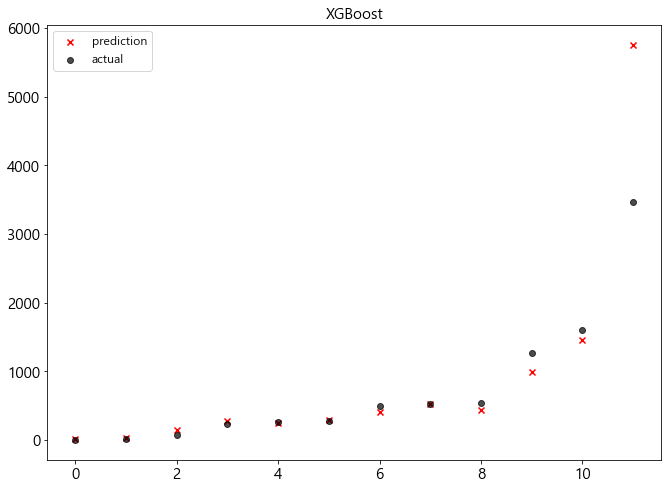

r2 score = 0.502
                              model           r2
0                   Voting Ensemble 0.9312117513
1                  Lasso(alpha=100) 0.9296301631
2                  Ridge(alpha=100) 0.9292676297
3                   Ridge(alpha=10) 0.9234800922
4                   Lasso(alpha=10) 0.9228892912
5                    Ridge(alpha=1) 0.9225178884
6                    Lasso(alpha=1) 0.9224613302
7                  Ridge(alpha=0.1) 0.9224166448
8                  Lasso(alpha=0.1) 0.9224110126
9                 Ridge(alpha=0.01) 0.9224064691
10                Lasso(alpha=0.01) 0.9224059062
11               Ridge(alpha=0.001) 0.9224054511
12               Lasso(alpha=0.001) 0.9224053948
13              Ridge(alpha=0.0001) 0.9224053492
14              Lasso(alpha=0.0001) 0.9224053436
15                 LinearRegression 0.9224053379
16         ElasticNet(l1_ratio=0.8) 0.9201655048
17            RandomForest Ensemble 0.9198740374
18         ElasticNet(l1_ratio=0.5) 0.9168135059
19 

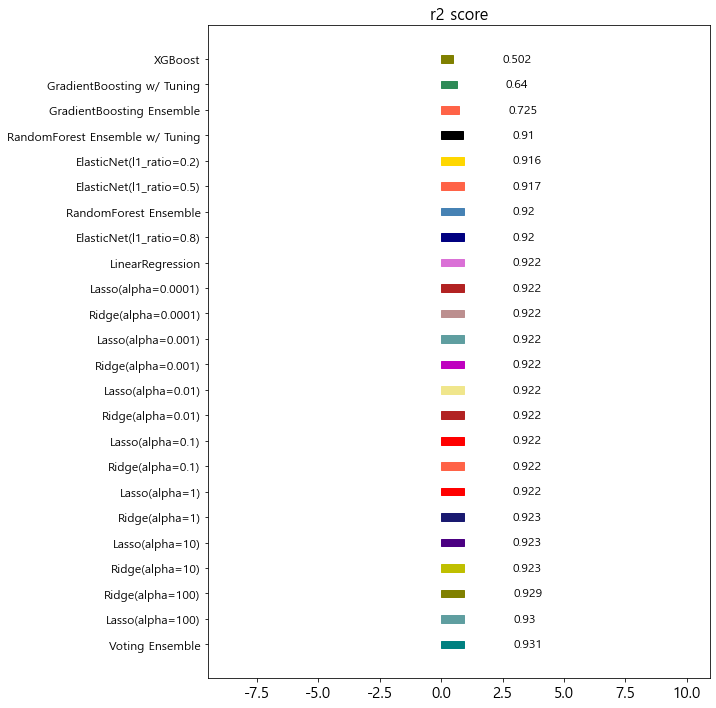

In [35]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)
r2_eval('XGBoost', xgb_pred, y_test)

In [36]:
params = {
    'n_estimators': [100, 500, 1000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [7, 8], 
    'subsample': [0.8, 0.9],
    'max_features': [0.8, 0.9, 1]
}

In [37]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(XGBRegressor(), params, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(x_train, y_train)

[17:26:50] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:26:50] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:26:50] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [38]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 0.8,
 'n_estimators': 1000,
 'subsample': 0.8}

[17:33:15] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




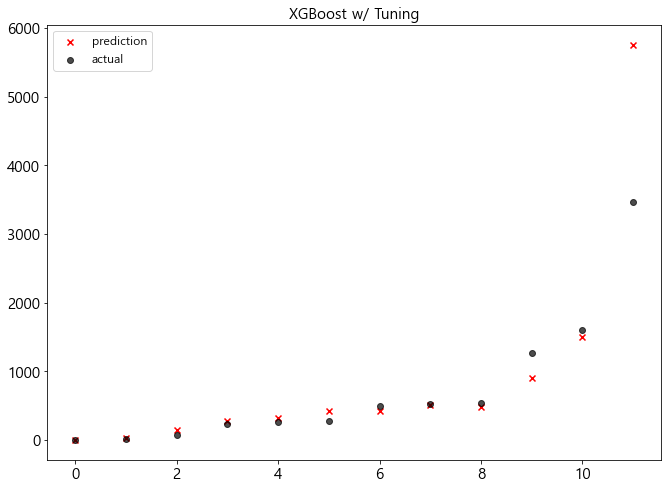

r2 score = 0.496
                              model           r2
0                   Voting Ensemble 0.9312117513
1                  Lasso(alpha=100) 0.9296301631
2                  Ridge(alpha=100) 0.9292676297
3                   Ridge(alpha=10) 0.9234800922
4                   Lasso(alpha=10) 0.9228892912
5                    Ridge(alpha=1) 0.9225178884
6                    Lasso(alpha=1) 0.9224613302
7                  Ridge(alpha=0.1) 0.9224166448
8                  Lasso(alpha=0.1) 0.9224110126
9                 Ridge(alpha=0.01) 0.9224064691
10                Lasso(alpha=0.01) 0.9224059062
11               Ridge(alpha=0.001) 0.9224054511
12               Lasso(alpha=0.001) 0.9224053948
13              Ridge(alpha=0.0001) 0.9224053492
14              Lasso(alpha=0.0001) 0.9224053436
15                 LinearRegression 0.9224053379
16         ElasticNet(l1_ratio=0.8) 0.9201655048
17            RandomForest Ensemble 0.9198740374
18         ElasticNet(l1_ratio=0.5) 0.9168135059
19 

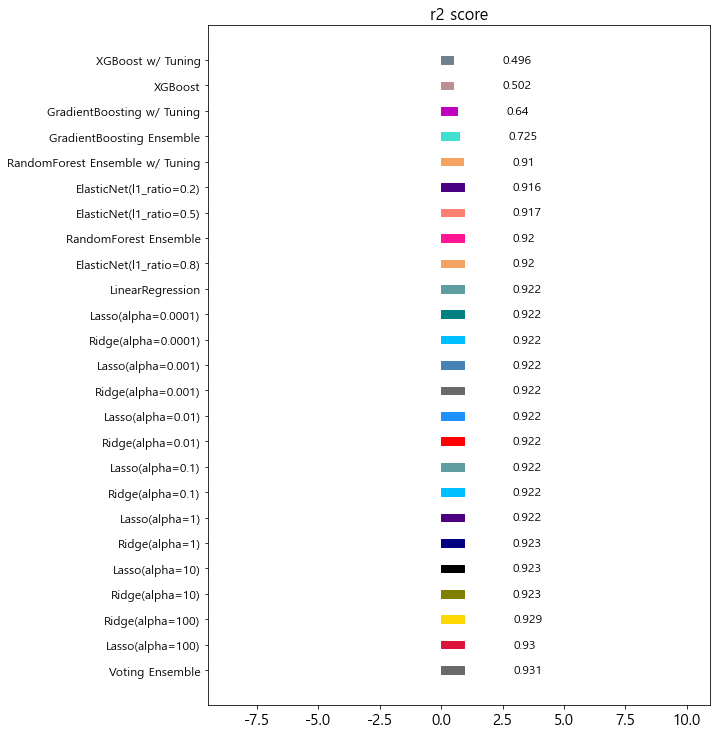

In [39]:
# 튜닝
xgb = XGBRegressor(random_state=42, **grid_search.best_params_)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)
r2_eval('XGBoost w/ Tuning', xgb_pred, y_test)

#### 9. 부스팅 (Boosting) 앙상블 ▶ Light GBM 
* Xgboost 대비 성능향상 및 자원소모 최소화

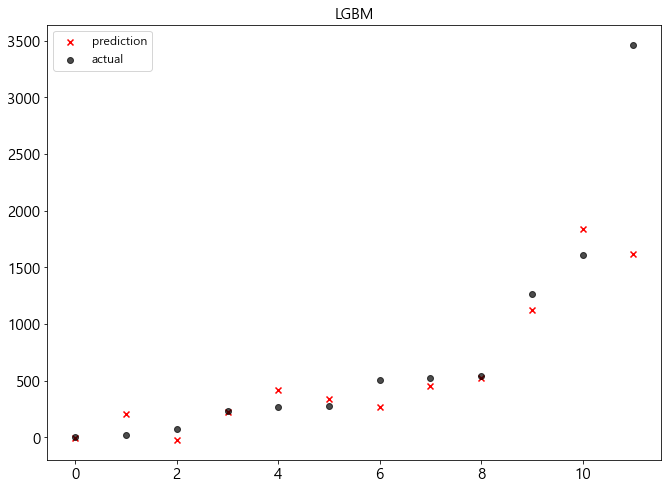

r2 score = 0.664
                              model           r2
0                   Voting Ensemble 0.9312117513
1                  Lasso(alpha=100) 0.9296301631
2                  Ridge(alpha=100) 0.9292676297
3                   Ridge(alpha=10) 0.9234800922
4                   Lasso(alpha=10) 0.9228892912
5                    Ridge(alpha=1) 0.9225178884
6                    Lasso(alpha=1) 0.9224613302
7                  Ridge(alpha=0.1) 0.9224166448
8                  Lasso(alpha=0.1) 0.9224110126
9                 Ridge(alpha=0.01) 0.9224064691
10                Lasso(alpha=0.01) 0.9224059062
11               Ridge(alpha=0.001) 0.9224054511
12               Lasso(alpha=0.001) 0.9224053948
13              Ridge(alpha=0.0001) 0.9224053492
14              Lasso(alpha=0.0001) 0.9224053436
15                 LinearRegression 0.9224053379
16         ElasticNet(l1_ratio=0.8) 0.9201655048
17            RandomForest Ensemble 0.9198740374
18         ElasticNet(l1_ratio=0.5) 0.9168135059
19 

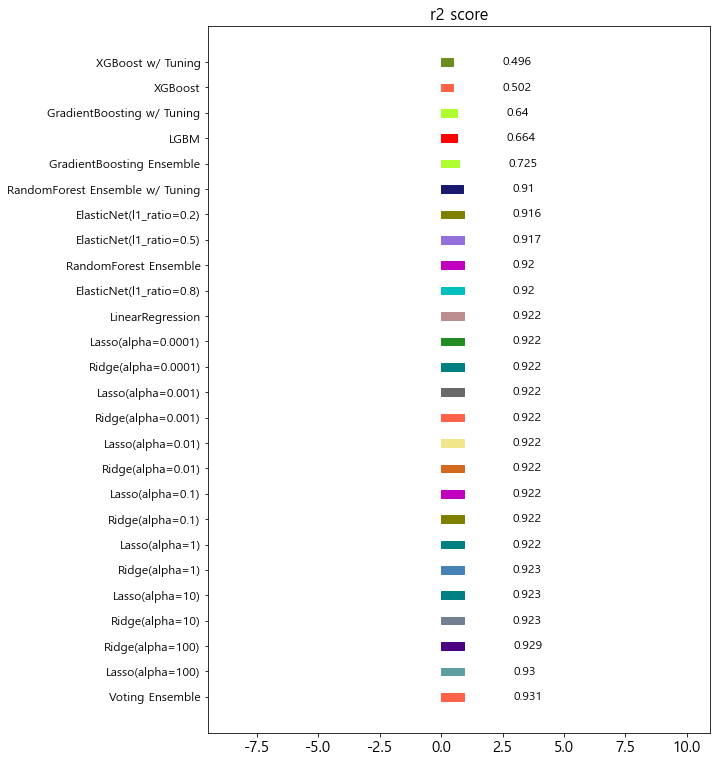

In [40]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state=42)
lgbm.fit(x_train, y_train)
lgbm_pred = lgbm.predict(x_test)
r2_eval('LGBM', lgbm_pred, y_test)

In [41]:
params = {
    'n_estimators': [500, 1000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'max_depth': [7, 8], 
    'colsample_bytree': [0.8, 0.9], 
    'subsample': [0.8, 0.9,],
}

In [42]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(LGBMRegressor(), params, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [7, 8], 'n_estimators': [500, 1000],
                         'subsample': [0.8, 0.9]},
             scoring='r2')

In [43]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 7,
 'n_estimators': 500,
 'subsample': 0.8}

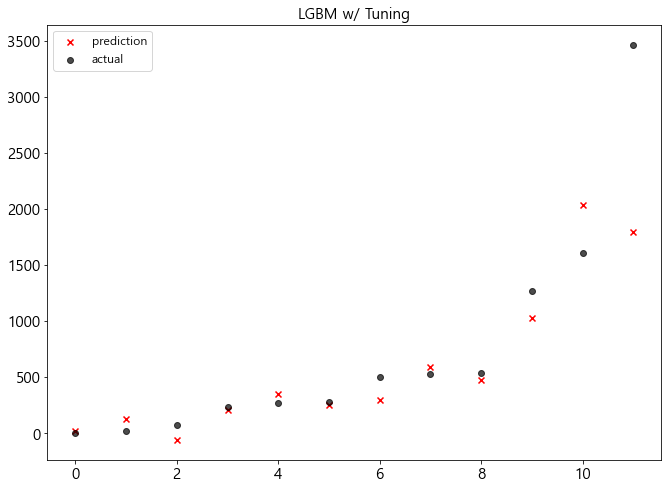

r2 score = 0.713
                              model           r2
0                   Voting Ensemble 0.9312117513
1                  Lasso(alpha=100) 0.9296301631
2                  Ridge(alpha=100) 0.9292676297
3                   Ridge(alpha=10) 0.9234800922
4                   Lasso(alpha=10) 0.9228892912
5                    Ridge(alpha=1) 0.9225178884
6                    Lasso(alpha=1) 0.9224613302
7                  Ridge(alpha=0.1) 0.9224166448
8                  Lasso(alpha=0.1) 0.9224110126
9                 Ridge(alpha=0.01) 0.9224064691
10                Lasso(alpha=0.01) 0.9224059062
11               Ridge(alpha=0.001) 0.9224054511
12               Lasso(alpha=0.001) 0.9224053948
13              Ridge(alpha=0.0001) 0.9224053492
14              Lasso(alpha=0.0001) 0.9224053436
15                 LinearRegression 0.9224053379
16         ElasticNet(l1_ratio=0.8) 0.9201655048
17            RandomForest Ensemble 0.9198740374
18         ElasticNet(l1_ratio=0.5) 0.9168135059
19 

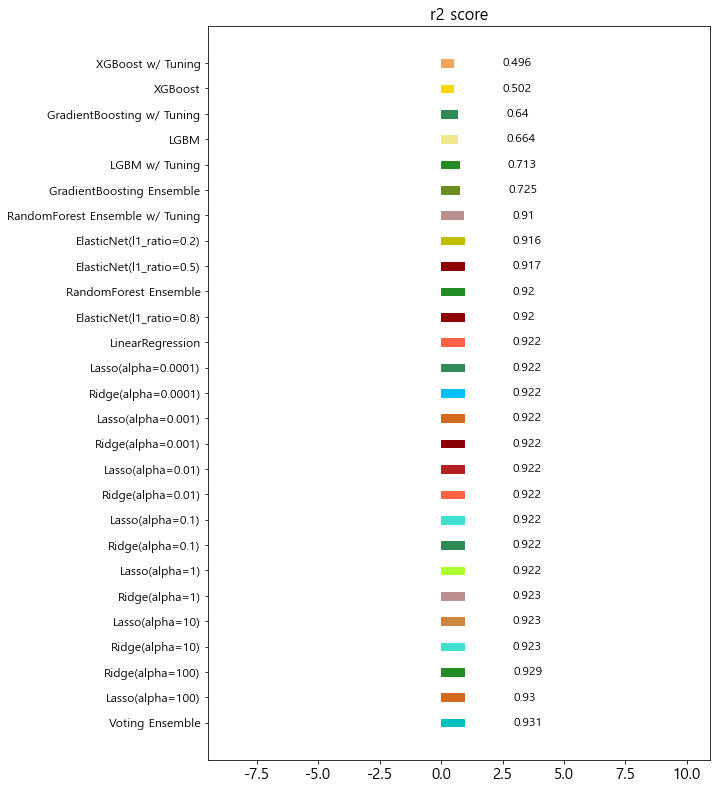

In [44]:
# 튜닝
lgbm = LGBMRegressor(random_state=42, **grid_search.best_params_)
lgbm.fit(x_train, y_train)
lgbm_pred = lgbm.predict(x_test)
r2_eval('LGBM w/ Tuning', lgbm_pred, y_test)

* r2_score 가장 높은 VotingRegressor 모델로 회귀분석 진행

## 3.3. 회귀분석
###  (1) 예측 데이터 선정 – 주차장확보율 부족한 거주지

In [45]:
# 예측 데이터 필터링
XX = 격자별_최종데이터[(격자별_최종데이터['주차장확보율']<1)&(격자별_최종데이터['주차장확보율']!=0)&(격자별_최종데이터['가구수']!=0)][['가구수','주차가능차량수','주차장확보율','불법주정차','버스','주거시설']]
yy = 격자별_최종데이터[(격자별_최종데이터['주차장확보율']<1)&(격자별_최종데이터['주차장확보율']!=0)&(격자별_최종데이터['가구수']!=0)][['주차면수']]

### (2) 회귀분석 - VotingRegressor

In [46]:
# 회귀분석
linear_reg = LinearRegression()
ridge = Ridge(alpha=100)
lasso = Lasso(alpha=100)
elasticnet = ElasticNet(alpha=100, l1_ratio=0.8)

single_models = [
    ('linear_reg', linear_reg), 
    ('ridge', ridge), 
    ('lasso', lasso), 
    ('elasticnet', elasticnet)
]

voting_regressor = VotingRegressor(single_models, n_jobs=-1)

voting_regressor.fit(X, y)

voting_pred = voting_regressor.predict(XX)

### (3) 교차검증

In [47]:
# 교차검증
from sklearn.model_selection import cross_val_score

r2_scores = cross_val_score(voting_regressor, XX, yy, cv=3)

print("R2: ", np.round(r2_scores, 3))
print("average R2: ", np.round(np.mean(r2_scores), 3))

R2:  [0.655 0.742 0.3  ]
average R2:  0.566


## 3.4. 결과해석
### (1) 회귀분석 결과

In [48]:
# 예측치
pd.DataFrame(voting_pred).rename(columns={0:'예측치'})

,예측치
0,250.1644146341
1,56.0435189944
2,176.7291879110
3,-20.6992169858
4,-131.0658965853
5,-103.8431689166
6,566.5485289270
7,-293.0089753717
8,-333.0939153353
9,521.7075605196


In [49]:
# 실제 주차면수
yy

,주차면수
3,147.0000000000
13,316.0000000000
27,10.0000000000
28,21.0000000000
29,76.0000000000
33,7.0000000000
34,135.0000000000
36,217.0000000000
37,41.0000000000
48,456.0000000000


###   (2) '주차장필요' 칼럼 생성 = (회귀분석)예측치 – (현재)주차면수

In [50]:
주차예측 = pd.concat([yy.reset_index(), pd.DataFrame(voting_pred).rename(columns={0:'예측치'})], axis=1)
주차예측['주차장필요'] = 0
주차예측['주차장필요'] = 주차예측['예측치']-주차예측['주차면수']
주차예측.sort_values(by='주차장필요', ascending=False)

,index,주차면수,예측치,주차장필요
56,182,422.0000000000,1810.7339623367,1388.7339623367
79,403,188.0000000000,1370.7118261306,1182.7118261306
82,425,188.0000000000,1114.8241471581,926.8241471581
71,256,132.0000000000,1015.3679894521,883.3679894521
75,294,254.0000000000,1112.0297148447,858.0297148447
27,94,868.0000000000,1582.6863316929,714.6863316929
43,128,537.0000000000,1207.5961449386,670.5961449386
93,467,36.0000000000,551.4212043754,515.4212043754
57,183,171.0000000000,631.2483642710,460.2483642710
6,34,135.0000000000,566.5485289270,431.5485289270


###  (3) 주차수요 격자 필터링 및 우선순위 선정

In [51]:
# 격자 추가
GetCompasData('SBJ_2107_003', '15', '15.부산시남구_격자(300X300).geojson')
df= gpd.read_file("15.부산시남구_격자(300X300).geojson")

def multipolygon_to_coordinates(x): 
    lon, lat = x[0].exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 
def polygon_to_coordinates(x): 
    lon, lat = x.exterior.xy 
    return [[x, y] for x, y in zip(lon, lat)] 

# geometry를 coordinate 형태로
df['coordinates'] = df['geometry'].apply(polygon_to_coordinates)

# 300X300 grid에서 central point 찾기
df_list = []
for i in df['geometry']:
    cent = i.centroid
    df_list.append(cent)
df['geo_cent'] = 0
df['geo_cent'] = df_list 

# 쉬운 분석을 위한 임의의 grid id
df['grid_id']=0
idx = []
for i in range(len(df)):
    idx.append(i)
df['grid_id'] = pd.DataFrame(idx)

# 정규화
주차예측_k = 주차예측.sort_values(by='주차장필요', ascending=False)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
mm_scaler = scaler.fit(주차예측_k[['주차장필요']] )
df_mm = mm_scaler.transform(주차예측_k[['주차장필요']])
주차예측_k['정규화_주차장필요'] = df_mm

주차예측_k = pd.merge(df, 주차예측_k.rename(columns={'index':'grid_id'}), on='grid_id', how='inner')
주차예측_k.head(2)

,id,geometry,coordinates,geo_cent,grid_id,주차면수,예측치,주차장필요,정규화_주차장필요
0,9,"POLYGON ((129.06301 35.14370, 129.06570 35.143...","[[129.06300949513243, 35.14369554725283], [129...",POINT (129.0643569680586 35.14259368895314),3,147.0000000000,250.1644146341,103.1644146341,0.3229364954
1,44,"POLYGON ((129.06570 35.14370, 129.06840 35.143...","[[129.0657044409848, 35.14369554725283], [129....",POINT (129.067051913911 35.14259368895314),13,316.0000000000,56.0435189944,-259.9564810056,0.1316937061


In [52]:
rlt = pd.merge(격자별_최종데이터, 주차예측_k, on='grid_id', how='inner').sort_values(by='가구수')

# 필요한 주차면수('주차장필요') 0보다 작거나 같은 값 버림 + 가구수 하위 25% 버림
rlt1 = rlt[(rlt['주차장필요']>0)&(rlt['가구수']>=rlt['가구수'].describe()[4])]

# 가구수& 주차장필요수로 필터링함.
rlt1['불법주정차순위']=np.nan
rlt1['주차장확보율순위']=np.nan

# 최종순위 정하기
rlt1=rlt1.sort_values(by='정규화_불법주정차',ascending=False)# 높을수록 순위 낮음.
rlt1['불법주정차순위']=rlt1.reset_index().index+1
rlt1=rlt1.sort_values(by='주차장확보율') # 확보율이 낮을수록 순위높음.
rlt1['주차장확보율순위']=rlt1.reset_index().index+1
rlt1['최종순위']=rlt1.불법주정차순위+rlt1.주차장확보율순위

rlt2 = rlt1.sort_values(by='최종순위')
# rlt2.to_csv('최종_1차회귀_46개.csv')
# rlt2.id_x.values

격자순위 = rlt2.rename(columns={'id_y':'id', 'geometry_y':'geometry','coordinates_y':'coordinates', 'geo_cent_y':'geo_cent'})[['id','geometry','coordinates','geo_cent','grid_id','행정동','최종순위']]
격자순위.head(2)

,id,geometry,coordinates,geo_cent,grid_id,행정동,최종순위
82,618,"POLYGON ((129.10882 35.11284, 129.11152 35.112...","[[129.10882357462253, 35.11283808609127], [129...",POINT (129.1101710475487 35.11173581022271),425,용호4동,16
10,113,"POLYGON ((129.07109 35.14590, 129.07379 35.145...","[[129.0710943326895, 35.14589920418718], [129....",POINT (129.0724418056157 35.14479737572),49,문현1동,21


# 4. 최종결과 및 평가
## 4.1. 주차용량 제시

###  (1) 격자별 주차용량 제안

*      가능주차면수 = 면적합계($m^2$) / 주차1대당 소요면적($m^2$)
*      필요주차면수 = 주차장필요면수

In [53]:
# 2차 필터링 > 최종격자 29개 도출
최종격자29개 = pd.read_csv('최종데이터/최종_1차회귀_46개.csv')

# 순위별 주차수요 격자 시각화
최종격자29개_시각화 = 최종격자29개.drop(['Unnamed: 0','geometry','coordinates','geo_cent','grid_id'], axis=1)
최종격자29개_시각화 = pd.merge(격자순위, 최종격자29개_시각화, on='id', how='inner')
최종격자29개_시각화.head(2)

,id,geometry,coordinates,geo_cent,grid_id,행정동,최종순위,면적합계,가능주차면수,필요주차면수
0,618,"POLYGON ((129.10882 35.11284, 129.11152 35.112...","[[129.10882357462253, 35.11283808609127], [129...",POINT (129.1101710475487 35.11173581022271),425,용호4동,16,117.1000000000,3.9033333333,216.2958188218
1,113,"POLYGON ((129.07109 35.14590, 129.07379 35.145...","[[129.0710943326895, 35.14589920418718], [129....",POINT (129.0724418056157 35.14479737572),49,문현1동,21,147.0000000000,4.9000000000,103.1644146341


## 4.2. 주차수요 예상격자 시각화

###  (1) 최종격자 선정

* 주차가능한 29개 격자 선정

* 붉은색이 진할수록  우선순위 높은 격자

In [54]:
import pydeck as pdk

# Make layer
layer = pdk.Layer( 'PolygonLayer', 
                  최종격자29개_시각화,
                  get_polygon='coordinates',
                  get_fill_color='[최종순위 * 255, 0, 0, (84 - 최종순위) * 4]', # 붉은색이 진할수록 주차장설치 시급
                  pickable=True,
                  auto_highlight=True 
                 ) 

# Set the viewport location 
center = [129.09209955486202, 35.12048306804342] 
view_state = pdk.ViewState( 
    longitude=center[0], 
    latitude=center[1], 
    zoom=11
) 

# Render 
map30 = pdk.Deck(layers=[layer], initial_view_state=view_state,
             map_style='mapbox://styles/mapbox/outdoors-v11',
             mapbox_key = "pk.eyJ1IjoiamNsYXJhODExIiwiYSI6ImNrZzF4bWNhdTBpNnEydG54dGpxNDEwajAifQ.XWxOKQ-2HqFBVBYa-XoS-g"
            )
map30.to_html()

In [55]:
# 특정 구역에 몰린 형태 →  동별 주차제안
최종격자29개_시각화.행정동.value_counts()

용호3동    6
문현1동    3
문현4동    3
용호2동    3
문현2동    2
대연4동    2
용호4동    2
감만2동    2
감만1동    2
용당동     1
문현3동    1
대연6동    1
용호1동    1
Name: 행정동, dtype: int64

## 4.3. 동별 주차제안

###  (1) 용호동
   * 3층 이내 낮은 건물 밀집 지역 → 노후화 된 건물 매입 후 주차장 설치
   ![nn](용호동.png)

###  (2) 용당동
* 부경대학교 용당캠퍼스 & 산/항구 위치 → 사용되지 않는 토지 매입 후 주차장으로 설치
![nn](용당동.png)

###  (3) 감만동
*    산/항구 위치 & 좁고 복잡한 지형 → 이전한 부산외대 캠퍼스 부지 활용한 주차장 설치
![nn](감만동.png)

###  (4) 문현동
* 문현금융단지 조성 & 황령산 이용 등산객 → 금융단지 주변 건물 매입, 돌산공원 이용 주차장 설치
![nn](문현동.png)

###  (5) 대연동
* 황령산 이용 등산객 → 낮은 고도의 산을 이용한 주차장 설치
![nn](대연동.png)

# 5. 분석결과
## 5.1. 좌표 30개 선정

In [65]:
최종좌표 = 최종격자29개_시각화.drop(['id','coordinates','grid_id','geo_cent','면적합계','필요주차면수','최종순위'], axis=1)
최종좌표 = 최종좌표.rename(columns={'가능주차면수':'주차장 면적(㎡)','행정동':'주차장 위치'})

# 주차용량 계산
lst=[]
for x in 최종좌표['주차장 면적(㎡)']/10:
    lst.append(str(x)+"대")
주차용량pd = pd.DataFrame(lst).rename(columns={0:'주차용량'})
최종좌표 = pd.concat([최종좌표,주차용량pd], axis=1)

# X 좌표, Y 좌표 계산
lon=[]
lat=[]
for index, row in pd.DataFrame(최종좌표.geometry).iterrows():
    lon.append(row.geometry.centroid.x)
    lat.append(row.geometry.centroid.y)
최종좌표['X 좌표'] = lat
최종좌표['Y 좌표'] = lon
최종좌표 = 최종좌표.drop('geometry', axis=1)

# 하위 격자 제거
최종좌표 = 최종좌표.drop(index=[27,28], axis=0)

# 최종순위
최종좌표 = 최종좌표.reset_index()
최종좌표['index'] = 최종좌표['index']+1
최종좌표 = 최종좌표.rename(columns={'index':'설치순위'})
최종좌표['비고'] = ['노후화 된 건물 매입 제안','금융단지 주변 건물 매입, 돌산공원 이용 제안','노후화 된 건물 매입 제안','금융단지 주변 건물 매입, 돌산공원 이용 제안','금융단지 주변 건물 매입, 돌산공원 이용 제안','이전한 부산외대 캠퍼스 부지 활용 제안','이전한 부산외대 캠퍼스 부지 활용 제안','사용되지 않는 토지 매입 제안','금융단지 주변 건물 매입, 돌산공원 이용 제안','낮은 고도의 산 이용 제안',
                    '노후화 된 건물 매입 제안','금융단지 주변 건물 매입, 돌산공원 이용 제안','노후화 된 건물 매입 제안','금융단지 주변 건물 매입, 돌산공원 이용 제안','낮은 고도의 산 이용 제안','금융단지 주변 건물 매입, 돌산공원 이용 제안','금융단지 주변 건물 매입, 돌산공원 이용 제안','이전한 부산외대 캠퍼스 부지 활용 제안','낮은 고도의 산 이용 제안','이전한 부산외대 캠퍼스 부지 활용 제안',
                    '노후화 된 건물 매입 제안','노후화 된 건물 매입 제안','노후화 된 건물 매입 제안','노후화 된 건물 매입 제안','노후화 된 건물 매입 제안','노후화 된 건물 매입 제안','노후화 된 건물 매입 제안']

# 노상주차장 추가
노상데이터 = {
    '설치순위':[28, 29, 30],
    '주차장 위치':['감만2동','감만1동','문현4동'],
    'X 좌표':[35.12391, 35.11242, 35.13091],
    'Y 좌표':[129.08761, 129.08639, 129.07058],
    '주차장 면적(㎡)':[200, 150, 210],
    '주차용량':['20대','15대','21대'],
    '비고':['노상주차장 설치 제안','노상주차장 설치 제안','노상주차장 설치 제안']
}
노상데이터 = pd.DataFrame(노상데이터)
최종좌표 = pd.concat([최종좌표,노상데이터])

# 최종파일
최종좌표 = 최종좌표[['설치순위','주차장 위치','X 좌표','Y 좌표','주차장 면적(㎡)','주차용량','비고']].set_index('설치순위')
최종좌표

,주차장 위치,X 좌표,Y 좌표,주차장 면적(㎡),주차용량,비고
설치순위,,,,,,
1,용호4동,35.1117358102,129.1101710475,3.9033333333,0.3903333333333333대,노후화 된 건물 매입 제안
2,문현1동,35.1447973757,129.0724418056,4.9000000000,0.49000000000000005대,"금융단지 주변 건물 매입, 돌산공원 이용 제안"
3,용호2동,35.1139403321,129.1128659934,9.7333333333,0.9733333333333333대,노후화 된 건물 매입 제안
4,문현2동,35.1425936890,129.0643569681,15.8266666667,1.5826666666666664대,"금융단지 주변 건물 매입, 돌산공원 이용 제안"
5,문현1동,35.1470010028,129.0751367515,53.2000000000,5.32대,"금융단지 주변 건물 매입, 돌산공원 이용 제안"
6,감만2동,35.1227578234,129.0859165349,10.7666666667,1.0766666666666667대,이전한 부산외대 캠퍼스 부지 활용 제안
7,감만2동,35.1205535400,129.0859165349,4.5000000000,0.45대,이전한 부산외대 캠퍼스 부지 활용 제안
8,용당동,35.1161447944,129.0940013724,18.3333333333,1.8333333333333328대,사용되지 않는 토지 매입 제안
9,문현4동,35.1315743602,129.0697468598,3.2333333333,0.32333333333333336대,"금융단지 주변 건물 매입, 돌산공원 이용 제안"


In [66]:
최종좌표.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 1 to 30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   주차장 위치     30 non-null     object 
 1   X 좌표       30 non-null     float64
 2   Y 좌표       30 non-null     float64
 3   주차장 면적(㎡)  30 non-null     float64
 4   주차용량       30 non-null     object 
 5   비고         30 non-null     object 
dtypes: float64(3), object(3)
memory usage: 1.6+ KB


## 5.2. 좌표 30개 시각화
* folium을 이용한 빨간색 Marker로 표시
* Marker를 클릭하면 설치순위가 popup한다.

In [85]:
import folium
mapp = folium.Map(location=[35.12048306804342,129.09209955486202], zoom_start=13)

for name, lat, lon in zip(최종좌표.reset_index().설치순위, 최종좌표['X 좌표'], 최종좌표['Y 좌표']):
    markerr = folium.Marker([lat,lon],
                             popup = name,
                             icon = folium.Icon(color='red'))
    markerr.add_to(mapp)
mapp

## 5.3. 제출파일

In [87]:
최종좌표.to_csv('분석결과.csv')

## 5.4. 한계점 및 느낀점

* 행정동이 아닌 격자를 통해 진행되었기 때문에 동일한 격자 내에서도 다른 성격의 지역이 포함될 수 있음.
* 격자별로 인구수, 자동차등록대수 데이터를 수급할 수 있었다면 더 정확하게 예측할 수 있었을 것임.
* 격자 내 인구나 가구수 파악이 정확하지 않음.
* 학습데이터가 충분치 않아 과적합(Overfitting)이 발생했을 것이라 생각함.
* 특정 지점을 찾아내기 위한 특성들에 대한 정보들이 누락된 경우가 많아 다소 아쉬움. (공시지가, 건물면적, 가구수 등등)
* 다중공선성이있는 독립변수들은 제거하여 회귀분석을 진행했는데, 부분 최소제곱법또는 주성분 분석을 더 공부하여 다른 방식으로도 다중공선성문제를 해결하지 못해 아쉬움.
* 회귀모델 성능평가지표로 가장 적합하다고 생각한 R2 결정계수를 사용했는데, 다른 지표인 MAE, MSE, RMSE를 이용한 결과는 어떻게 다를까라는궁금증이 남았음.
* 회귀분석을 통한 예측 시 실제값과의차이가 예상보다 크게 나타나서, 하이퍼파라미터튜닝 및 교차검증을 더 체계적으로 하여 성능을 최적화하고 편향과 분산의 균형을 맞추고자 함.